## Application to the analysis of the US supreme Court

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
sns.set(style="whitegrid")
plt.rc('text')
plt.rc('font', family='serif')

In [78]:
spike_times = np.loadtxt(r'..\data\US_SupremeCourt_n9_N895.txt')
pandas_spikes = pd.read_csv(r'..\data\US_SupremeCourt_n9_N895.txt')

# intervals = np.diff(spike_times)
# print(f"Number of spikes: {len(spike_times)}")
# print(f"Number of intervals: {len(intervals)}")
# print(f"Range of spike times: {spike_times[0]} to {spike_times[-1]} ms")
# print(f"Min interval: {np.min(intervals):.3f} ms")
# print(f"Max interval: {np.max(intervals):.3f} ms")
# print(f"Mean interval: {np.mean(intervals):.3f} ms")

# # Plot the distribution of interspike intervals
# plt.figure(figsize=(10, 6))
# hist, bins, _ = plt.hist(intervals, bins=50, density=True, alpha=0.7, 
#                          color='skyblue', edgecolor='black')
# plt.xlabel('Inter-spike Interval τ (ms)')
# plt.ylabel('Probability Density P(τ)')
# plt.title('Distribution of Inter-spike Intervals')
# plt.savefig('..\\results\\neuron_model\\interspike_intervals.pdf', dpi=300, bbox_inches='tight')\
    

In [79]:
# Convert the np array to a list of strings
vote_patterns = []
for value in spike_times:
    str_value = str(int(value))
    if value == 0:
        pattern = "000000000"
    else:
        # pad with zeros to ensure each string is 9 characters long
        if len(str_value) < 9:
            pattern = str_value.zfill(9)
        else:
            pattern = str_value[-9:]
    vote_patterns.append(pattern)
    
# Count unique patterns
unique_patterns = set(vote_patterns)
N_max = len(unique_patterns)
print(f"Number of unique voting patterns (N_max): {N_max}")

Number of unique voting patterns (N_max): 128


In [95]:
judge_names = ['JS', 'RG', 'DS', 'SB', 'SO', 'AK', 'WR', 'AS', 'CT']
df = pd.DataFrame([list(pattern) for pattern in vote_patterns], 
                  columns=judge_names)

# Convert string values to integers
df = df.astype(int)
# Map 0s to -1s to match the paper's representation
df = df.replace(0, -1)
avg_votes = df.mean()


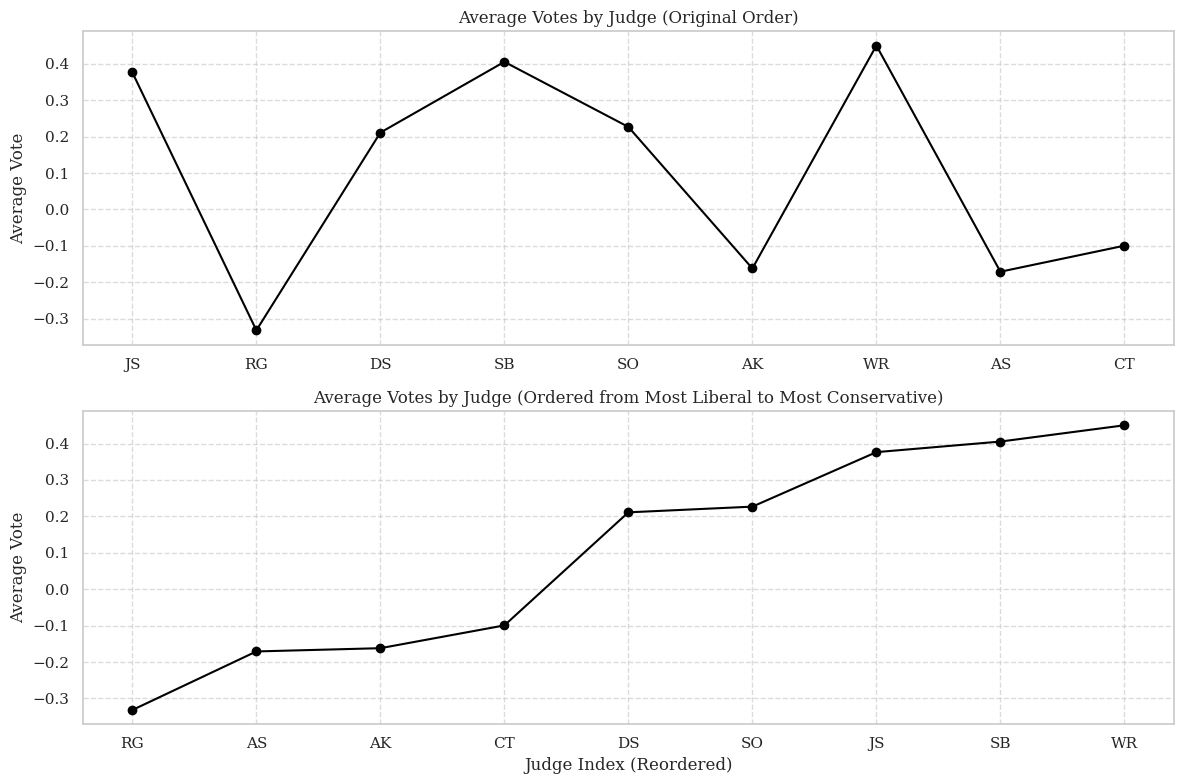

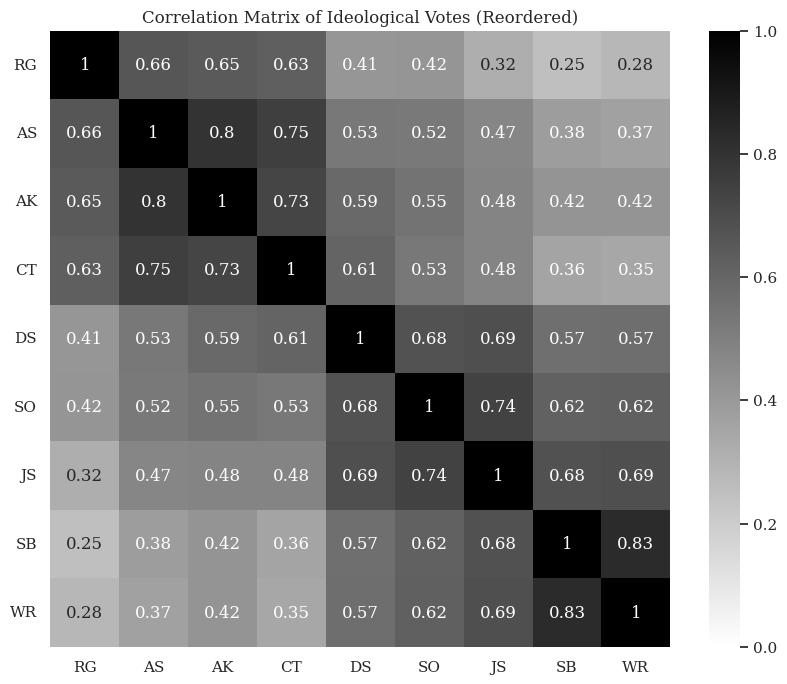

In [ ]:
judge_indices = np.arange(1, 10)

# Plot the average votes (before reordering)
plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(judge_indices, avg_votes.values, 'o-', color='black')
plt.ylabel('Average Vote')
plt.title('Average Votes by Judge (Original Order)')
plt.xticks(judge_indices, judge_names)
plt.grid(True, linestyle='--', alpha=0.7)
# Reorder indices by average votes (smallest to largest)
reordered_indices = avg_votes.sort_values().index
avg_votes_reordered = avg_votes[reordered_indices]
reordered_names = [judge_names[judge_names.index(i)] for i in reordered_indices]

# Plot the reordered average votes
plt.subplot(212)
plt.plot(judge_indices, avg_votes_reordered.values, 'o-', color='black')
plt.ylabel('Average Vote')
plt.xlabel('Judge Index (Reordered)')
plt.title('Average Votes by Judge (Ordered from Most Liberal to Most Conservative)')
plt.xticks(judge_indices, reordered_names)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('..\\results\\us_court\\reordered.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix with the new ordering
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix.loc[reordered_indices, reordered_indices], 
            cmap='gray_r', vmin=0, vmax=1,annot=True)
plt.title('Correlation Matrix of Ideological Votes (Reordered)')
plt.xticks(np.arange(len(reordered_names))+0.5, reordered_names)
plt.yticks(np.arange(len(reordered_names))+0.5, reordered_names, rotation=0)
plt.savefig('..\\results\\us_court\\correlation_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [110]:
hi = np.loadtxt(r'..\data\hi_ussc_unsorted.txt')
jij = np.loadtxt(r'..\data\Jij_ussc_unsorted.txt')

hi_df = pd.DataFrame({'Judge': judge_names, 'h_i': hi})
# From smallest to largest average vote
reordered_indices = ['RG', 'AS', 'AK', 'CT', 'DS', 'SO', 'JS', 'SB', 'WR']
# Reorder the h_i values
hi_reordered = [hi_df.loc[hi_df['Judge'] == judge, 'h_i'].values[0] for judge in reordered_indices]

AttributeError: QuadMesh.set() got an unexpected keyword argument 'fontsize'

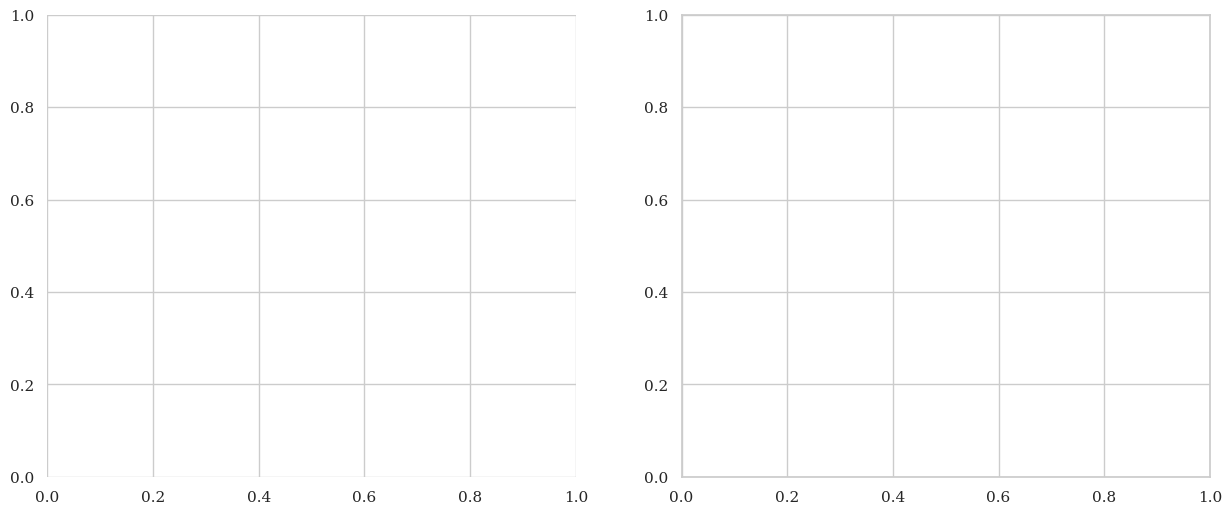

In [ ]:
# Initialize a 9x9 matrix with zeros
J_matrix = np.zeros((9, 9))

# Fill the matrix with the provided J_ij values
idx = 0
for i in range(9):
    for j in range(i+1, 9):
        J_matrix[i, j] = jij[idx]
        J_matrix[j, i] = jij[idx]  # Symmetric matrix
        idx += 1
J_df = pd.DataFrame(J_matrix, index=judge_names, columns=judge_names)

# Reorder the J_ij matrix
J_reordered = J_df.loc[reordered_indices, reordered_indices]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot h_i heatmap
sns.heatmap(pd.DataFrame(hi_reordered, index=reordered_indices, columns=['h_i']), 
            cmap='RdBu_r', center=0, ax=axs[0], vmin=-1, vmax=1)
axs[0].set_title('Local Field Parameters (h_i)', fontsize=20)
axs[0].set_ylabel('Judge',fontsize=20)


# Plot J_ij heatmap
sns.heatmap(J_reordered, cmap='RdBu_r', vmin=-1, vmax=1.0, ax=axs[1],annot=True)
axs[1].set_title('Pairwise Coupling Parameters (J_ij)', fontsize=20)
axs[1].set_xlabel('Judge', fontsize=20)
axs[1].set_ylabel('Judge', fontsize=20)

plt.tight_layout()
plt.savefig('..\\results\\us_court\\another_correlation.pdf', dpi=300, bbox_inches='tight')
plt.show()